In [155]:
import numpy as np 
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

The model is specified by 
\begin{align}
    B^T_A W
        &= \frac{1}{\beta} [ W^0 + \alpha_1 \sum_{i=1}^D W_i^1(A) \\
        &+ \alpha_2 \sum_{j=1}^D \sum_{k=j+1} W^2_{j,k}(A)
\end{align}

where
* $B_A^T$ is a feature vector that represents which combination of widgets to show
* $W_0$ is the mean click through rate
* $W_1$ is a vector with first-order interaction parameters (i.e. how each asset influences the click through rate)
* $W_2$ is a matrix with second-order interaction parameters (i.e. the influence of combinations of assets on the click through rate
* $\beta$ is a scaling parameter

# Examples

## Example 1

* 2 asset types, headers and images, with $N_1=3$, $N_2=2$

In [315]:
N_1 = 3
N_2 = 2
N = N_1 + N_2

* layouts

In [316]:
layouts = list(itertools.product(range(N_1), range(N_2)))
layouts = pd.get_dummies(pd.DataFrame(layouts).astype(str), prefix=['header', 'image'])
layouts = layouts.values
layouts

array([[1, 0, 0, 1, 0],
       [1, 0, 0, 0, 1],
       [0, 1, 0, 1, 0],
       [0, 1, 0, 0, 1],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 0, 1]], dtype=uint8)

* $W_0 \sim N(0,1)$
* $W_1 \sim N(0,1)$ 
* $W_2 \sim N(0,1)$

In [317]:
W_0 = np.random.normal(size=1)
W_1 = np.random.normal(size=N)
W_2 = np.random.normal(size=(N, N))

In [318]:
W_0, W_1, W_2

(array([-0.14212954]),
 array([-0.8750639 ,  1.12541456,  0.19975295,  0.09389791,  1.19315653]),
 array([[ 0.65094297,  0.92952966,  0.82591663, -1.14899457, -1.10621572],
        [-0.00963626, -0.18746551, -0.80665895, -1.21844682, -0.91442306],
        [-1.30267775,  0.62671073, -0.13706889, -0.16597829,  0.7232315 ],
        [ 0.44657301, -1.33812654, -1.97009417,  0.00442469,  0.52889138],
        [ 0.72842321, -0.82950258,  0.23391194,  2.96199907, -0.32797214]]))

* $\alpha_1$ = 1
* $\alpha_2$ = 0.5

In [320]:
α_1 = 1
α_2 = 0.5

In [321]:
A_1 = layouts[0]
A_1

array([1, 0, 0, 1, 0], dtype=uint8)

In [323]:
def compute_variance(β):
    values = [(1/β) * (
        W_0 
        + α_1 * np.dot(A, W_1) 
        + α_2 * np.sum(np.triu(np.outer(A, A), 1) * W_2)
    ) for A in layouts]
    return np.var(values)

def find_beta(desired_variance, initial_guess=10):
    return scipy.optimize.fsolve(
        lambda x: compute_variance(x) - desired_variance, 
        initial_guess
    )

In [324]:
desired_variance = 0.02
β = find_beta(desired_variance)
β

array([7.90714253])

$P(R|A_1) = \Phi ( R * B^T_A W)$

In [330]:
# In the paper they do not mention how they get the mean around 0.12
# Here we subtract 0.3 from the values, as the mean is around 0.5
scipy.stats.norm.cdf(
    1 * (1 / β) * (
        W_0 
        + α_1 * np.dot(A_1, W_1) 
        + α_2 * np.sum(np.triu(np.outer(A_1, A_1), 1) * W_2)
    )
) - 0.3

array([0.12488074])

* $A_2$ = [1, 0, 1]

In [331]:
A_2 = layouts[2]
A_2

array([0, 1, 0, 1, 0], dtype=uint8)

$P(R|A_2) = \Phi ( R * B^T_A W)$

In [332]:
# In the paper they do not mention how they get the mean around 0.12
# Here we subtract 0.3 from the values, as the mean is around 0.5
scipy.stats.norm.cdf(
    1 * (1 / β) * (
        W_0 
        + α_1 * np.dot(A_2, W_1) 
        + α_2 * np.sum(np.triu(np.outer(A_2, A_2), 1) * W_2)
    )
) - 0.3

array([0.22359638])

In [333]:
all_products = [
    (1 / β) * (
        W_0 
        + α_1 * np.dot(A, W_1) 
        + α_2 * np.sum(np.triu(np.outer(A, A), 1) * W_2)
    ) for A in layouts
]

In [334]:
# In the paper they do not mention how they get the mean around 0.12
# Here we subtract 0.3 from the values, as the mean is around 0.5
all_probabilities = [
    scipy.stats.norm.cdf(
        1 * product
    )[0] - 0.3 for product in all_products
]

In [335]:
all_probabilities

[0.12488074066744376,
 0.18097897334031426,
 0.223596376339737,
 0.2860623881061553,
 0.20345763813216017,
 0.28079056801075225]

<AxesSubplot:ylabel='Count'>

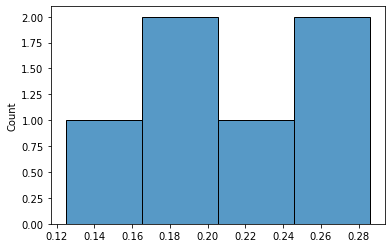

In [336]:
sns.histplot(all_probabilities)

## Example 2

In [304]:
N_1 = 10
N_2 = 15
N = N_1 + N_2

In [305]:
layouts = list(itertools.product(range(N_1), range(N_2)))
layouts = pd.get_dummies(pd.DataFrame(layouts).astype(str), prefix=['header', 'image'])
layouts = layouts.values

In [306]:
W_0 = np.random.normal(size=1)
W_1 = np.random.normal(size=N)
W_2 = np.random.normal(size=(N, N))

In [307]:
α_1 = 1
α_2 = 2

In [308]:
def compute_variance(β):
    values = [(1/β) * (
        W_0 
        + α_1 * np.dot(A, W_1) 
        + α_2 * np.sum(np.triu(np.outer(A, A), 1) * W_2)
    ) for A in layouts]
    return np.var(values)

def find_beta(desired_variance, initial_guess=10):
    return scipy.optimize.fsolve(
        lambda x: compute_variance(x) - desired_variance, 
        initial_guess
    )

In [309]:
desired_variance = 0.02
β = find_beta(desired_variance)
β

array([17.38133044])

In [310]:
all_products = [
    (1 / β) * (
        W_0 
        + α_1 * np.dot(A, W_1) 
        + α_2 * np.sum(np.triu(np.outer(A, A), 1) * W_2)
    ) for A in layouts
]

In [313]:
# In the paper they do not mention how they get the mean around 0.12
# Here we subtract 0.3 from the values, as the mean is around 0.5
all_probabilities = [
    scipy.stats.norm.cdf(
        1 * product
    )[0] - 0.3 for product in all_products
]

<AxesSubplot:ylabel='Count'>

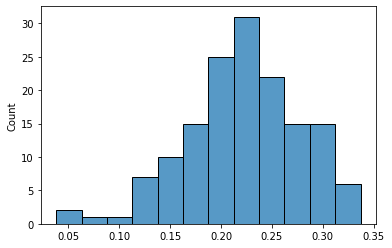

In [314]:
sns.histplot(all_probabilities)